In [1]:
import pandas as pd
from utils.preprocessing import load_daily_data, load_monthly_data
from utils.baseline import run_baseline_forecast_daily, run_baseline_forecast_monthly
from utils.statistical import run_statistical_forecast_daily, run_statistical_forecast_monthly
from utils.machine_learning import run_machine_learning_forecast_daily, run_machine_learning_forecast_monthly
from utils.deep_learning import run_deep_learning_forecast_daily, run_deep_learning_forecast_monthly
from utils.constants import FREQ_DAILY, FREQ_MONTHLY, FAMILY_BASELINE, FAMILY_STATISTICAL, FAMILY_MACHINE_LEARNING, FAMILY_DEEP_LEARNING, SPLIT_VAL


c:\Users\loren\anaconda3\envs\AIS3_TIS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-29 16:23:54,061	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-12-29 16:23:54,388	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## METRICS:

Table:

model - name  
category  
monthly/daily  
Mae  
rmse  
mape  


## Visualizations

- Best model
- Best model / category
- Best 3 models
- Daily / monthly compare
- Error of best model


In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

def plot_forecasts_OLD(gt, pred, gt_label="Ground Truth", figsize=(14,5)):

    forecast_cols = [c for c in pred.columns if c not in ["unique_id", "ds", "y"]]
    if not forecast_cols:
        raise ValueError("No forecast columns found in pred!")

    plt.figure(figsize=figsize)

    # Ground Truth
    plt.plot(gt["ds"], gt["y"], label=gt_label, color="#1D3557", linewidth=2)

    # Color palette for multiple models
    palette = sns.color_palette("pastel", n_colors=len(forecast_cols))

    # Plot all forecast models
    for i, col in enumerate(forecast_cols):
        plt.plot(pred["ds"], pred[col], label=str(i+1) + ': ' + col,
                 color=palette[i], linestyle="-", linewidth=2)


    plt.axvline(pred["ds"].min(), color="gray", linestyle=":", label="Forecast Start")

    # Formatting
    plt.title("Forecast vs Ground Truth", fontsize=16)
    plt.xlabel("Datum", fontsize=12)
    plt.ylabel("Preis", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    # Better date formatting
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.xticks(rotation=45)

    plt.show()


In [3]:
from utils.metric_utils import load_overall_metrics, merge_prediction_dfs, find_n_best_models

In [4]:
daily_train, daily_val, daily_test = load_daily_data(use_existing=True)
monthly_train, monthly_val, monthly_test = load_monthly_data(use_existing=True)

In [5]:
base_daily_val, base_daily_test = run_baseline_forecast_daily(daily_train, daily_val, daily_test, use_existing=True)
base_monthly_val, base_monthly_test = run_baseline_forecast_monthly(monthly_train, monthly_val, monthly_test, use_existing=True)

In [6]:
statis_daily_val, statis_daily_test = run_statistical_forecast_daily(daily_train, daily_val, daily_test, use_existing=True)
statis_monthly_val, statis_monthly_test = run_statistical_forecast_monthly(monthly_train, monthly_val, monthly_test, use_existing=True)

In [7]:
ml_daily_val, ml_daily_test = run_machine_learning_forecast_daily(daily_train, daily_val, daily_test, use_existing=True)
ml_monthly_val, ml_monthly_test = run_machine_learning_forecast_monthly(monthly_train, monthly_val, monthly_test, use_existing=True)

In [8]:
dl_daily_val, dl_daily_test = run_deep_learning_forecast_daily(daily_train, daily_val, daily_test, use_existing=True)
dl_monthly_val, dl_monthly_test = run_deep_learning_forecast_monthly(monthly_train, monthly_val, monthly_test, use_existing=True)

In [9]:
overall_metrics = load_overall_metrics()
merged_daily = merge_prediction_dfs(base_daily_val, base_daily_test, statis_daily_val, statis_daily_test, ml_daily_val, ml_daily_test, dl_daily_val, dl_daily_test)
merged_monthly = merge_prediction_dfs(base_monthly_val, base_monthly_test, statis_monthly_val, statis_monthly_test, ml_monthly_val, ml_monthly_test, dl_monthly_val, dl_monthly_test)

In [10]:
data = find_n_best_models(overall_metrics, 1, merged_daily, merged_monthly)

In [11]:
data

{0: {'name': 'LGBMRegressor_Lag',
  'family': 'ml',
  'frequency': 'D',
  'data':     unique_id         ds  LGBMRegressor_Lag
  0     Austria 2025-01-01         101.688448
  1     Austria 2025-01-02         101.802452
  2     Austria 2025-01-03          96.010350
  3     Austria 2025-01-04          89.030283
  4     Austria 2025-01-05          89.496594
  ..        ...        ...                ...
  725   Austria 2026-12-18         104.596315
  726   Austria 2026-12-19          78.149141
  727   Austria 2026-12-20          63.008524
  728   Austria 2026-12-21          95.061265
  729   Austria 2026-12-22          98.135814
  
  [730 rows x 3 columns]}}

In [12]:
from utils.fc_visualization import plot_forecasts, plot_residuals


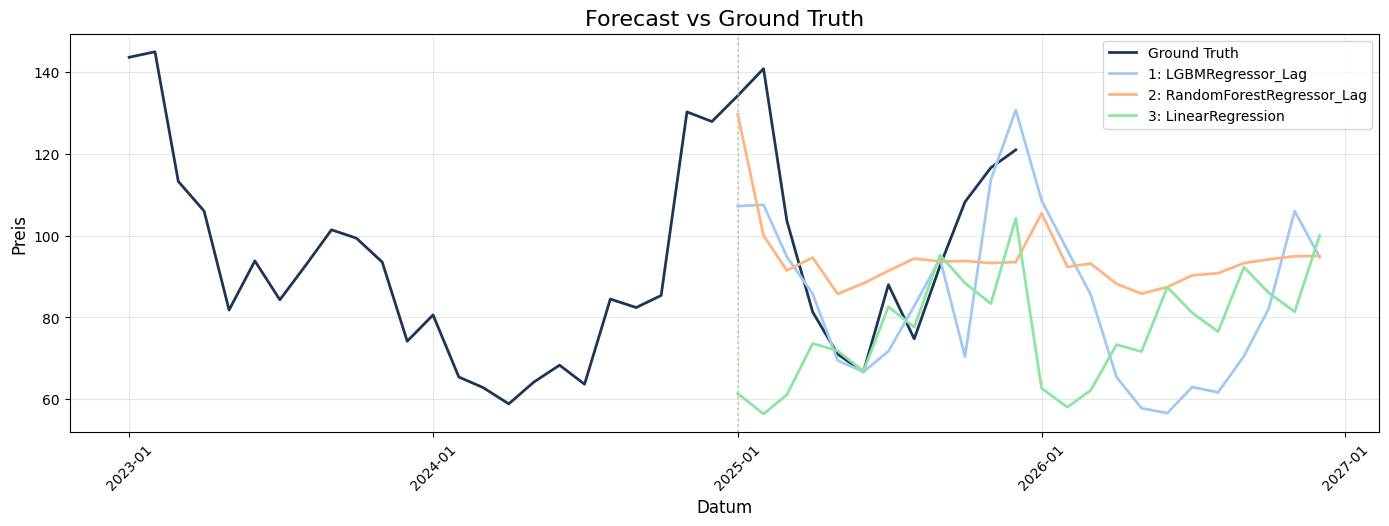

In [13]:
data2 = find_n_best_models(overall_metrics, 3, merged_daily, merged_monthly)
plot_forecasts(data2, 'test')

RESIDUALS

In [14]:
best = find_n_best_models(overall_metrics, 1, merged_daily, merged_monthly)

In [15]:
def _get_ground_truth(frequency: str, start_val: str, end_val: str) -> pd.DataFrame:
    """Load ground truth data based on frequency and split."""
    if frequency == FREQ_DAILY:
        data_train, data_val, data_test = load_daily_data(use_existing=True)
    elif frequency == FREQ_MONTHLY:
        data_train, data_val, data_test = load_monthly_data(use_existing=True)
    else:
        raise ValueError(f"Unsupported frequency: {frequency}")
    
    data = pd.concat([data_train, data_val], axis=0, ignore_index=True)

    return data[(data['ds'] >= start_val) & (data['ds'] < end_val)]

In [16]:
from utils.constants import DATE_RANGE_VAL_EXTENDED


In [17]:
best

{0: {'name': 'LGBMRegressor_Lag',
  'family': 'ml',
  'frequency': 'D',
  'data':     unique_id         ds  LGBMRegressor_Lag
  0     Austria 2025-01-01         101.688448
  1     Austria 2025-01-02         101.802452
  2     Austria 2025-01-03          96.010350
  3     Austria 2025-01-04          89.030283
  4     Austria 2025-01-05          89.496594
  ..        ...        ...                ...
  725   Austria 2026-12-18         104.596315
  726   Austria 2026-12-19          78.149141
  727   Austria 2026-12-20          63.008524
  728   Austria 2026-12-21          95.061265
  729   Austria 2026-12-22          98.135814
  
  [730 rows x 3 columns]}}

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


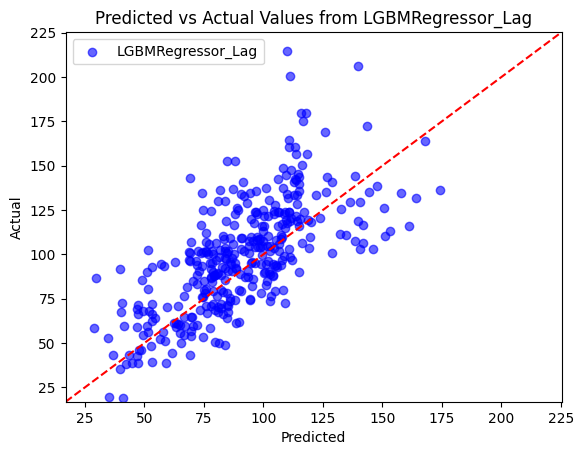

In [18]:
plot_residuals(best)

In [19]:
geil = find_n_best_models(overall_metrics, 1, merged_daily, merged_monthly, best_per_family=True, frequencies=[FREQ_DAILY, FREQ_MONTHLY])

In [ ]:
best_3_mon = find_n_best_models(overall_metrics, 3, merged_daily, merged_monthly, frequencies=[FREQ_MONTHLY])


dict_keys([1, 2, 3])